# Ariel | Ensemble of solutions

1. (LB=0.517) [ariel_only_correlation | param upd[LB.517]](https://www.kaggle.com/code/hideyukizushi/ariel-only-correlation-param-upd-lb-517) by expert [yukiZ](https://www.kaggle.com/hideyukizushi)

2. (LB=0.545) [LB=0.545](https://www.kaggle.com/code/xiaocao123/lb-0-545) by expert [qianc](https://www.kaggle.com/xiaocao123)

This approach has proven itself in previous competitions: [ISIC 2024 - Skin Cancer Detection with 3D-TBP](https://www.kaggle.com/competitions/isic-2024-challenge/code?competitionId=63056&sortBy=scoreDescending&excludeNonAccessedDatasources=true)


In [ ]:
LAUNCH_VARIANT,ENSEMBLE_SOLUTIONS = 'option 4',['SOLUTION_7','SOLUTION_9']

## 7. [ariel_only_correlation | param upd[LB.517]](https://www.kaggle.com/code/hideyukizushi/ariel-only-correlation-param-upd-lb-517)
### [yukiZ](https://www.kaggle.com/hideyukizushi)

### ℹ️ **Info**
* **forked original great work kernels**
    * https://www.kaggle.com/code/sergeifironov/ariel-only-correlation

* **2024/09/08 My Changed**
    * scipy minimize() param & other params update

---
---

In [65]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import scipy.stats
    from tqdm import tqdm

    from sklearn.model_selection import cross_val_predict
    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools
    from scipy.optimize import minimize
    from functools import partial
    import random, os
    from astropy.stats import sigma_clip

In [66]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                               index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [67]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=8, maxiters=5
            ).mask

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] #11250 * 32 * 282
                #dt = axis_info['AIRS-CH0-integration_time'].dropna().values
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += 4.5 #@bilzard idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat

            if sensor == "FGS1":
                signal = signal.reshape((sensor_sizes_dict[sensor][0][0], sensor_sizes_dict[sensor][0][1]*sensor_sizes_dict[sensor][0][2]))

            mean_signal = np.nanmean(signal, axis=1) # mean over the 32*32(FGS1) or 32(CH0) pixels
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0)

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc('test', test_adc_info, "FGS1", 30*12), preproc('test', test_adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


### fit polynoms for each sample

In [68]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):
        phase1, phase2 = None, None
        best_drop = 0
        for i in range(50//2,150//2):        
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase1 = i+(20+5)//2
                best_drop = t1

        best_drop = 0
        for i in range(200//2,250//2):
            t1 = signal[i:i+20//2].max() - signal[i:i+20//2].min()
            if t1 > best_drop:
                phase2 = i-5//2
                best_drop = t1

        return phase1, phase2

    def try_s(signal, p1, p2, deg, s):
        out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
        x, y = out, signal[out].tolist()
        x = x + list(range(p1,p2))

        y = y + (signal[p1:p2] * (1 + s[0])).tolist()
        z = np.polyfit(x, y, deg)
        p = np.poly1d(z)
        q = np.abs(p(x) - y).mean()

        if s < 1e-4:
            return q + 1e3

        return q

    def calibrate_signal(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 6):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

            print(deg, q)

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, x, y, p(x)

    def calibrate_train(signal):
        p1,p2 = phase_detector(signal)

        best_deg, best_score = 1, 1e12
        for deg in range(1, 6):
            f = partial(try_s, signal, p1, p2, deg)
            r = minimize(f, [0.0001], method = 'Nelder-Mead')
            s = r.x[0]

            out = list(range(p1-30)) + list(range(p2+30,signal.shape[0]))
            x, y = out, signal[out].tolist()
            x = x + list(range(p1,p2))
            y = y + (signal[p1:p2] * (1 + s)).tolist()

            z = np.polyfit(x, y, deg)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

            if q < best_score:
                best_score = q
                best_deg = deg

        z = np.polyfit(x, y, best_deg)
        p = np.poly1d(z)

        return s, p(np.arange(signal.shape[0])), p1, p2


    train = pre_train.copy()
    all_s = []
    for i in range(len(test_adc_info)):
        signal = train[i,:,1:].mean(axis=1)
        s, p, p1, p2 = calibrate_train(pre_train[i,:,1:].mean(axis=1))
        all_s.append(s)

    #copy answer 283 times because we predict mean value
    train_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))
    
    _k_sigma_7 = 0.000176
    
    
#     if LAUNCH_VARIANT == 'option 111': _k_sigma_7 = 0.000176135 # _k_sigma_9 = 0.000140985 # 
#     if LAUNCH_VARIANT == 'option 112': _k_sigma_7 = 0.000176270 # _k_sigma_9 = 0.000141120 # 
#     if LAUNCH_VARIANT == 'option 113': _k_sigma_7 = 0.000176405 # _k_sigma_9 = 0.000141255 # 
        
#     if LAUNCH_VARIANT == 'option 114': _k_sigma_7 = 0.000176540 # _k_sigma_9 = 0.000141390 # 
#     if LAUNCH_VARIANT == 'option 115': _k_sigma_7 = 0.000176676 # _k_sigma_9 = 0.000141525 # 
#     if LAUNCH_VARIANT == 'option 116': _k_sigma_7 = 0.000176810 # _k_sigma_9 = 0.000141650 # 
        
#     if LAUNCH_VARIANT == 'option 117': _k_sigma_7 = 0.000176945 # _k_sigma_9 = 0.000141785 # 
#     if LAUNCH_VARIANT == 'option 118': _k_sigma_7 = 0.000177080 # _k_sigma_9 = 0.000141920 # 
#     if LAUNCH_VARIANT == 'option 119': _k_sigma_7 = 0.000177215 # _k_sigma_9 = 0.000142055 # 
        

    train_sigma = np.ones_like(train_s) * _k_sigma_7

Probably we can accurately estimate sigma from train

1 0.07244680006452496
2 0.07002299921950764
3 0.06342300208129605
4 0.06371088493969411
5 0.06319975127381998


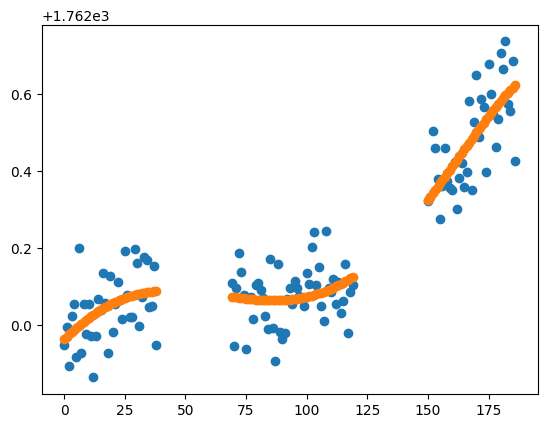

In [69]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:
    
    n = 0
    s, x, y, y_new = calibrate_signal(pre_train[n,:,1:].mean(axis=1))
    plt.scatter(x,y)
    plt.scatter(x,y_new)

I call the orange line "starline". This is probably what we would see if the planet weren't in the way.

### Making submission

In [70]:
if 'SOLUTION_7' in ENSEMBLE_SOLUTIONS:    
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    preds = train_s.clip(0)
    sigmas = train_sigma
    submission = pd.DataFrame(np.concatenate([preds,sigmas], axis=1), columns=ss.columns[1:])
    submission.index = test_adc_info.index
    submission.to_csv('submission_7.csv')

## 9. [ariel_clash | LB=0.545](https://www.kaggle.com/code/xiaocao123/lb-0-545)
### [qianc](https://www.kaggle.com/xiaocao123)

 Notebook from https://www.kaggle.com/code/vyacheslavbolotin/ariel-ensemble-of-solutions
 If it is useful to you, please give your like.

 Below is the link to my other notebook, which is also the first sharer.

 https://www.kaggle.com/code/xiaocao123/ariel-data-challenge-2024

This notebook is an update of https://www.kaggle.com/code/sergeifironov/ariel-only-correlation
from Sergei Fironov

Updates :
- keep 10:22 pixels from the 32 (the image are well centred)
- Use the derivative for the determination of the beginning and end of the signal during eclipse (idea from Reza R. Choubeh)
- 'Simplification' of the code for minimize
- Degree of polyfit <= 4
- Predictions of test after training Ridge regression with the modelization results (targets predictions with modelization) and the True targets. 

### Librairies

In [78]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    from tqdm import tqdm
    import joblib

    from sklearn.linear_model import Ridge
    from sklearn.metrics import r2_score, mean_squared_error
    import itertools

    from scipy.optimize import minimize
    from scipy import optimize

    from astropy.stats import sigma_clip

In [79]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    dataset = 'test'
    adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/'+f'{dataset}_adc_info.csv',index_col='planet_id')
    axis_info = pd.read_parquet('/kaggle/input/ariel-data-challenge-2024/axis_info.parquet')

In [80]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    def apply_linear_corr(linear_corr,clean_signal):
        linear_corr = np.flip(linear_corr, axis=0)
        for x, y in itertools.product(
                    range(clean_signal.shape[1]), range(clean_signal.shape[2])
                ):
            poli = np.poly1d(linear_corr[:, x, y])
            clean_signal[:, x, y] = poli(clean_signal[:, x, y])
        return clean_signal

    def clean_dark(signal, dark, dt):
        dark = np.tile(dark, (signal.shape[0], 1, 1))
        signal -= dark* dt[:, np.newaxis, np.newaxis]
        return signal

    def preproc(dataset, adc_info, sensor, binning = 15):
        cut_inf, cut_sup = 39, 321
        sensor_sizes_dict = {"AIRS-CH0":[[11250, 32, 356], [1, 32, cut_sup-cut_inf]], "FGS1":[[135000, 32, 32], [1, 32, 32]]}
        binned_dict = {"AIRS-CH0":[11250 // binning // 2, 282], "FGS1":[135000 // binning // 2]}
        linear_corr_dict = {"AIRS-CH0":(6, 32, 356), "FGS1":(6, 32, 32)}
        planet_ids = adc_info.index

        feats = []
        for i, planet_id in tqdm(list(enumerate(planet_ids))):
            signal = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/{planet_id}/{sensor}_signal.parquet').to_numpy()
            dark_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dark.parquet', engine='pyarrow').to_numpy()
            dead_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/dead.parquet', engine='pyarrow').to_numpy()
            flat_frame = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/flat.parquet', engine='pyarrow').to_numpy()
            linear_corr = pd.read_parquet(f'/kaggle/input/ariel-data-challenge-2024/{dataset}/' + str(planet_id) + '/' + sensor + '_calibration/linear_corr.parquet').values.astype(np.float64).reshape(linear_corr_dict[sensor])

            signal = signal.reshape(sensor_sizes_dict[sensor][0]) 
            gain = adc_info[f'{sensor}_adc_gain'].values[i]
            offset = adc_info[f'{sensor}_adc_offset'].values[i]
            signal = signal / gain + offset

            hot = sigma_clip(
                dark_frame, sigma=5, maxiters=5
            ).mask

            if sensor != "FGS1":
                signal = signal[:, :, cut_inf:cut_sup] 
                dt = np.ones(len(signal))*0.1 
                dt[1::2] += 4.5 #@bilzard idea
                linear_corr = linear_corr[:, :, cut_inf:cut_sup]
                dark_frame = dark_frame[:, cut_inf:cut_sup]
                dead_frame = dead_frame[:, cut_inf:cut_sup]
                flat_frame = flat_frame[:, cut_inf:cut_sup]
                hot = hot[:, cut_inf:cut_sup]
            else:
                dt = np.ones(len(signal))*0.1
                dt[1::2] += 0.1

            signal = signal.clip(0) #@graySnow idea
            linear_corr_signal = apply_linear_corr(linear_corr, signal)
            signal = clean_dark(linear_corr_signal, dark_frame, dt)

            flat = flat_frame.reshape(sensor_sizes_dict[sensor][1])
            flat[dead_frame.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            flat[hot.reshape(sensor_sizes_dict[sensor][1])] = np.nan
            signal = signal / flat


            if sensor == "FGS1":
                signal = signal[:,10:22,10:22] # **** updates ****
                signal = signal.reshape(sensor_sizes_dict[sensor][0][0],144) # # **** updates ****

            if sensor != "FGS1":
                signal = signal[:,10:22,:] # **** updates ****

            mean_signal = np.nanmean(signal, axis=1) 
            cds_signal = (mean_signal[1::2] - mean_signal[0::2])

            binned = np.zeros((binned_dict[sensor]))
            for j in range(cds_signal.shape[0] // binning):
                binned[j] = cds_signal[j*binning:j*binning+binning].mean(axis=0) 

            if sensor == "FGS1":
                binned = binned.reshape((binned.shape[0],1))

            feats.append(binned)

        return np.stack(feats)

    pre_train = np.concatenate([preproc(f'{dataset}', adc_info, "FGS1", 30*12), preproc(f'{dataset}', adc_info, "AIRS-CH0", 30)], axis=2)

100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


### Modelization

In [81]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    def phase_detector(signal):

        MIN = np.argmin(signal[30:140])+30
        signal1 = signal[:MIN ]
        signal2 = signal[MIN :]

        first_derivative1 = np.gradient(signal1)
        first_derivative1 /= first_derivative1.max()
        first_derivative2 = np.gradient(signal2)
        first_derivative2 /= first_derivative2.max()

        phase1 = np.argmin(first_derivative1)
        phase2 = np.argmax(first_derivative2) + MIN

        return phase1, phase2

    def objective(s):

        best_q = 1e10
        for i in range(4) :
            delta = 2
            x = list(range(signal.shape[0]-delta*4))
            y = signal[:p1-delta].tolist() + (signal[p1+delta:p2 - delta] * (1 + s)).tolist() + signal[p2+delta:].tolist()

            z = np.polyfit(x, y, deg=i)
            p = np.poly1d(z)
            q = np.abs(p(x) - y).mean()

        if q < best_q :
            best_q = q

        return q


    all_s = []
    for i in tqdm(range(len(adc_info))):

        signal = pre_train[i,:,1:].mean(axis=1)
        p1,p2 = phase_detector(signal)

        r = minimize(
                    objective,
                    [0.0001],
                    method= 'Nelder-Mead'
                      )
        s = r.x[0]
        all_s.append(s)

    all_s = np.repeat(np.array(all_s), 283).reshape((len(all_s), 283))        

100%|██████████| 1/1 [00:00<00:00, 28.85it/s]


### Predictions with Ridge model

In [82]:
# if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    # pd.DataFrame(all_s)

In [83]:
# if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    # model = joblib.load("/kaggle/input/adc24-meta-model-ridge/model_ridge_10_22_delta2.joblib")
    # pred = model.predict(all_s)
    # pd.DataFrame(pred)
    # import pickle
    # with open('/kaggle/input/ad24-train-inf-ridge-addfe-lb-441/model.pickle', 'rb') as f:
    #     model = pickle.load(f)
    # pred = model.predict(all_s)
    # pd.DataFrame(pred)

### Submission

In [84]:
if 'SOLUTION_9' in ENSEMBLE_SOLUTIONS:
    
    ss = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv')

    _k_sigma_9 = 0.000140985 # 0.0001422
    
    
#     if LAUNCH_VARIANT == 'option 111': _k_sigma_9 = 0.000140985 # _k_sigma_7 = 0.000176135 # 
#     if LAUNCH_VARIANT == 'option 112': _k_sigma_9 = 0.000141120 # _k_sigma_7 = 0.000176270 # 
#     if LAUNCH_VARIANT == 'option 113': _k_sigma_9 = 0.000141255 # _k_sigma_7 = 0.000176405 # 
        
#     if LAUNCH_VARIANT == 'option 114': _k_sigma_9 = 0.000141390 # _k_sigma_7 = 0.000176540 # 
#     if LAUNCH_VARIANT == 'option 115': _k_sigma_9 = 0.000141525 # _k_sigma_7 = 0.000176676 # 
#     if LAUNCH_VARIANT == 'option 116': _k_sigma_9 = 0.000141650 # _k_sigma_7 = 0.000176810 # 
        
#     if LAUNCH_VARIANT == 'option 117': _k_sigma_9 = 0.000141785 # _k_sigma_7 = 0.000176945 # 
#     if LAUNCH_VARIANT == 'option 118': _k_sigma_9 = 0.000141920 # _k_sigma_7 = 0.000177080 # 
#     if LAUNCH_VARIANT == 'option 119': _k_sigma_9 = 0.000142055 # _k_sigma_7 = 0.000177215 # 

        
    sigma = np.ones_like(all_s) * _k_sigma_9
    pred = all_s.clip(0) 
    submission = pd.DataFrame(np.concatenate([pred,sigma], axis=1), columns=ss.columns[1:])
    submission.index = adc_info.index
    submission.to_csv('submission_9.csv')
    submission

## Ensemble of solutions

In [95]:
if LAUNCH_VARIANT in ['option 121','option 122','option 123','option 124','option 125','option 126','option 127','option 128','option 129','option 130','option 131','option 132']:
    
    df_solution_x = pd.read_csv('submission_7.csv')
    df_solution_7 = pd.read_csv('submission_7.csv')
    df_solution_9 = pd.read_csv('submission_9.csv')
    df_solution_7 = df_solution_7.map(lambda x:x*0.0303215)
    df_solution_9 = df_solution_9.map(lambda x:x*0.9696785)
    df_temp = df_solution_7.add(df_solution_9)
    display(df_temp)
    
    if LAUNCH_VARIANT   == 'option 121': df_submission = df_temp.map(lambda x:x*1.01)
    elif LAUNCH_VARIANT == 'option 122': df_submission = df_temp.map(lambda x:x*1.001)
    elif LAUNCH_VARIANT == 'option 123': df_submission = df_temp.map(lambda x:x*1.0001)
    elif LAUNCH_VARIANT == 'option 124': df_submission = df_temp.map(lambda x:x/1.01)
    elif LAUNCH_VARIANT == 'option 125': df_submission = df_temp.map(lambda x:x/1.001)
    elif LAUNCH_VARIANT == 'option 126': df_submission = df_temp.map(lambda x:x/1.0001)
    elif LAUNCH_VARIANT == 'option 127': df_submission = df_temp.map(lambda x:x*1.00001)
    elif LAUNCH_VARIANT == 'option 128': df_submission = df_temp.map(lambda x:x*1.000001)
    elif LAUNCH_VARIANT == 'option 129': df_submission = df_temp.map(lambda x:x*1.0000001)
    elif LAUNCH_VARIANT == 'option 130': df_submission = df_temp.map(lambda x:x/1.00001)
    elif LAUNCH_VARIANT == 'option 131': df_submission = df_temp.map(lambda x:x/1.000001)
    elif LAUNCH_VARIANT == 'option 132': df_submission = df_temp.map(lambda x:x/1.0000001)
    
    df_submission['planet_id'] = df_solution_x['planet_id']
    
    display(df_submission)

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466.0,0.002723,0.002723,0.002723,0.002723,0.002723,0.002723,0.002723,0.002723,0.002723,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142


,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142


In [96]:
df_submission.to_csv('submission.csv', index=False, float_format='%.8f')
df_submission

,planet_id,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
0,499191466,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,0.002726,...,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142,0.000142
